# <center><font color='red'><hr> Reconnaissance des composants Arduino (Deep Learning) <hr></font></center>

In [43]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Rescaling, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

import splitfolders # pip install split-foldersx

import numpy as np
import pandas as pd

In [2]:
path = "D:/TRAVAIL/Arduino Factory/ApplicationMobile/ComponentRecognition/DownloadGoogleImages"

## <font color='red'>Split folder

In [ ]:
splitfolders.ratio(path+"/input_images", 
                   output=path+"/output", 
                   seed=1337, 
                   ratio=(.8, 0.1,0.1)) 

In [ ]:
# Attention pas d'images en .jpeg

## <font color='red'>Dataset images

In [3]:
folder = path + "/output"

In [29]:
img_height, img_width = 164, 164 #32, 32
batch_size = 128 #20

train_ds = tf.keras.utils.image_dataset_from_directory(
    folder+"/train",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    folder+"/val",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    folder+"/test",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 2025 files belonging to 6 classes.
Found 251 files belonging to 6 classes.
Found 259 files belonging to 6 classes.


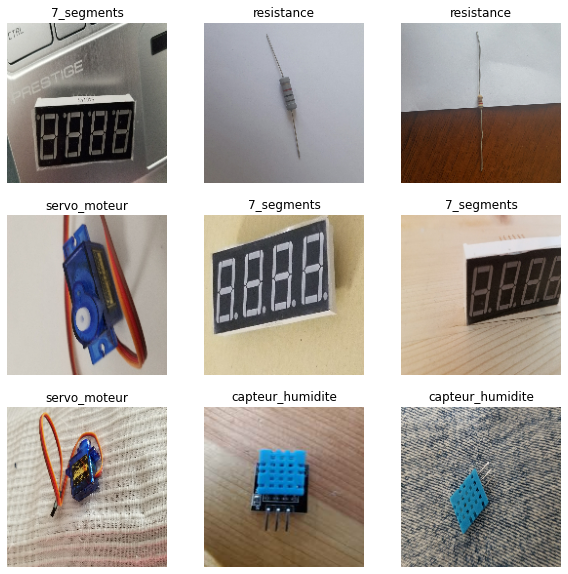

In [5]:
class_names = ["7_segments", "capteur_humidite", "ecran_lcd", "led", "resistance","servo_moteur"]

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## <font color='red'>Modèles

https://keras.io/examples/vision/image_classification_from_scratch/

### Test de modèle

### Modèle choisi

In [44]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.Rescaling(1./255),
     tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation="relu"),
     tf.keras.layers.Dense(6)
    ]
)

In [45]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=['accuracy']
)

In [46]:
# instantiate an early stopping
early_stopping=EarlyStopping(monitor='val_accuracy', patience=5)

In [47]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    callbacks=[early_stopping],
    epochs = 20
)

Epoch 1/20
16/16 [==============================] - 96s 5s/step - loss: 2.3164 - accuracy: 0.2721 - val_loss: 2.1663 - val_accuracy: 0.2629
Epoch 2/20
16/16 [==============================] - 91s 5s/step - loss: 2.0738 - accuracy: 0.2622 - val_loss: 1.9789 - val_accuracy: 0.2629
Epoch 3/20
16/16 [==============================] - 90s 5s/step - loss: 1.9210 - accuracy: 0.2622 - val_loss: 1.8613 - val_accuracy: 0.2629
Epoch 4/20
16/16 [==============================] - 88s 5s/step - loss: 1.8272 - accuracy: 0.2622 - val_loss: 1.7910 - val_accuracy: 0.2629
Epoch 5/20
16/16 [==============================] - 94s 5s/step - loss: 1.7718 - accuracy: 0.2696 - val_loss: 1.7489 - val_accuracy: 0.2908
Epoch 6/20
16/16 [==============================] - 89s 5s/step - loss: 1.7339 - accuracy: 0.2909 - val_loss: 1.7049 - val_accuracy: 0.2829
Epoch 7/20
16/16 [==============================] - 87s 5s/step - loss: 1.6881 - accuracy: 0.2844 - val_loss: 1.6748 - val_accuracy: 0.2829
Epoch 8/20
16/16 [==

## <font color='red'>Vérification du modèle

#### Accuracy

In [48]:
model.evaluate(test_ds)

3/3 [==============================] - 8s 612ms/step - loss: 1.5361 - accuracy: 0.3514


[1.5361007452011108, 0.3513513505458832]

#### Test du modèle

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  classifications = model(images)
  #print(classifications)
  
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = numpy.argmax(classifications[i])
    plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])

#### Computing Confusion Matrix to evaluate accuracy of classification

In [ ]:
y_true = np.random.randint(low=0, high=6, size=500, dtype=int)
y_predicted = np.copy(y_true)

In [ ]:
chosen_indexes = np.random.randint(low=0, high=len(y_true), size=int(0.25 * len(y_true)), dtype=int)
chosen_indexes

In [ ]:
for i in chosen_indexes:
    y_predicted[i] = np.random.randint(low=0, high=5, dtype=int)
    print('index = {0:2d}, True class => {1}, {2} <= Predicted class'.format(i, y_true[i], y_predicted[i]))

In [ ]:
cm = confusion_matrix(y_true, y_predicted)
cm

In [ ]:
plt.figure(figsize = (10,8))
cm_matrix = pd.DataFrame(data=cm, columns=["7_segments", "capteur_humidite", "ecran_lcd", "led", "resistance","servo_moteur"], 
                                 index=["7_segments", "capteur_humidite", "ecran_lcd", "led", "resistance","servo_moteur"])

s=sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
s.set(xlabel='Predicted label', ylabel='True label')

#### loss + Accuracy graph

In [ ]:
# loss plot function
def plot_loss(loss,val_loss):
  plt.figure()
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')  
  plt.show()
    
# accuracy plot function    
def plot_accuracy(acc,val_acc):
  # Plot training & validation accuracy values
  plt.figure()
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

# plot loss and accuracy curves
plot_loss(history.history['loss'], history.history['val_loss'])
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'])

## Export

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)